<a href="https://colab.research.google.com/github/alina0195/sketches/blob/main/BERT_corona_nlp_4_iunie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prereq

In [ ]:
! pip install Unidecode -q


     |████████████████████████████████| 235 kB 30.5 MB/s 


In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 29.2 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 17.1 MB/s 
     |████████████████████████████████| 596 kB 69.1 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 30.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=43cadc74a2eb166aa9940e54354609ba5de04f452659b3e6c334659603a18d56
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from pandas_profiling import ProfileReport


import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
import json
import re
import random
import time

In [ ]:
import torchmetrics
from torchmetrics.classification import Accuracy

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer
import html
import unicodedata
import unidecode
import re

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.utils import class_weight

# Device

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("You are running on CPU")

Tesla T4


In [ ]:
cpu_device = torch.device("cpu")

# CONFIG

Se vor compara modelele bertweet si CT-BERT

PRE_TRAINED_MODEL = 'digitalepidemiologylab/covid-twitter-bert-v2' --- MAX_LEN = 96

 PRE_TRAINED_MODEL = 'vinai/bertweet-covid19-base-uncased'  --- MAX_LEN= 128

CT-BERT V2 - A constant learning rate of 2e-5, as recommended on the official
BERT GitHub when doing domain-specific pretraining

Se vor mai testa diferite Learning_rates

In [ ]:
class config:
  SEED = 42
  K_FOLDS = 5
  MODEL_PATH = '/content/drive/MyDrive/models/bertweet_3_cls_corona_3_iunie_v2.pt'
  MAX_LEN = 128
  PRE_TRAINED_MODEL = 'digitalepidemiologylab/covid-twitter-bert-v2' 
  EPOCHS = 20
  LEARNING_RATE = 1e-5
  BATCH_SIZE = 32
  NUM_WORKERS = 2 
  EPS=1e-8
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Read dataframe

In [ ]:
path_train='/content/drive/MyDrive/dataset/Corona_NLP_train.csv'
path_test='/content/drive/MyDrive/dataset/Corona_NLP_test.csv'

In [ ]:
test_df = pd.read_csv(path_test, encoding='ISO-8859-1')
train_df = pd.read_csv(path_train, encoding='ISO-8859-1')

In [ ]:
def check_df(df, target_col):
  df= df.dropna(subset=[target_col])
  df=df.reset_index()
  return df

In [ ]:
print('Training samples: ', len(train_df))
print('Test samples: ', len(test_df))

Training samples:  41157
Test samples:  3798


In [ ]:
def plot_distribution(df, target_col, title):
  distribution = df[target_col].value_counts()
  plt.figure(figsize=(10,4))
  plt.title(title)
  plt.bar(distribution.index, distribution.values)
  plt.show()

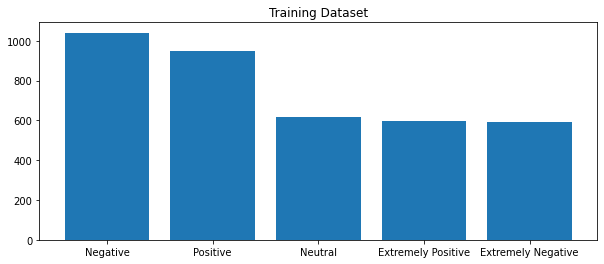

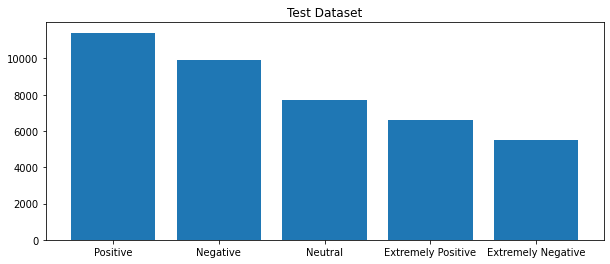

In [ ]:
%matplotlib inline
plot_distribution(train_df,'Sentiment','Training Dataset')
plot_distribution(test_df,'Sentiment','Test Dataset')

In [ ]:
df_train = check_df(train_df,'Sentiment')
df_test = check_df(test_df,'Sentiment')

In [ ]:
print('Training samples: ', len(train_df))
print('Test samples: ', len(test_df))

Training samples:  41157
Test samples:  3798


In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
train_df  = train_df[~train_df.duplicated(subset=['OriginalTweet'])==True]

In [ ]:
test_df = test_df[~test_df.duplicated(subset=['OriginalTweet'])==True]

In [ ]:
df_all = pd.concat((train_df, test_df), ignore_index=True)
print(df_all[~df_all.duplicated(subset=['OriginalTweet'])==True])
print(len(df_all))

       UserName  ScreenName             Location     TweetAt  \
0          3799       48751               London  16-03-2020   
1          3800       48752                   UK  16-03-2020   
2          3801       48753            Vagabonds  16-03-2020   
3          3802       48754                  NaN  16-03-2020   
4          3803       48755                  NaN  16-03-2020   
...         ...         ...                  ...         ...   
44950      3794       48746            Israel ??  16-03-2020   
44951      3795       48747       Farmington, NM  16-03-2020   
44952      3796       48748        Haverford, PA  16-03-2020   
44953      3797       48749                  NaN  16-03-2020   
44954      3798       48750  Arlington, Virginia  16-03-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1      advice Talk to your neighbours family to excha...            Posit

In [ ]:
df_all = df_all.sample(frac=1).reset_index(drop=True)
print('Samples:',len(df_all))

df_all.drop(['ScreenName'], inplace=True, axis=1)
df_all.drop(['Location'], inplace=True, axis=1)
df_all.drop(['TweetAt'], inplace=True, axis=1)
df_all.drop(['UserName'], inplace=True, axis=1)

Samples: 44955


In [ ]:
df_train, df_val = train_test_split(df_train, test_size = 0.1)

In [ ]:
print("Train Samples:",len(df_train),"\nValidation Samples:", len(df_val), "\nTest Samples:", len(df_test))

Train Samples: 37041 
Validation Samples: 4116 
Test Samples: 3798


In [ ]:
df_test.sample(5)

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1184,1184,1185,46137,NaN,13-03-2020,#Covid_19 8am supermarket in Brooklyn. ItÂs ...,Neutral
3104,3104,3105,48057,"New Jersey, USA",15-03-2020,Remarkable effort to prevent Covid _19 all aro...,Extremely Positive
3565,3565,3566,48518,Ottawa & Toronto,16-03-2020,Whatever you need that can't be found in a gro...,Neutral
2844,2844,2845,47797,NaN,15-03-2020,Covid-19 update: Thailand has entered phase 3....,Positive
3032,3032,3033,47985,"West Coast, Canada",15-03-2020,14 ways to fight the #coronavirus\r\r\n\r\r\nS...,Extremely Positive


In [ ]:
df_train.sample(5)

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
285,285,286,45238,Greater London,12-03-2020,****IMPORTANT MESSAGE FOR YOU ALL RE: COVID-19...,Positive
722,722,723,45675,"California, USA",12-03-2020,Apple Store locations have received new direct...,Positive
36,36,37,44989,"New York, NY",08-03-2020,Fellow Uni instructors! COVID-19 f2f class can...,Negative
2504,2504,2505,47457,"Washington, DC",14-03-2020,I figured out why there was no rush hour traff...,Extremely Negative
2995,2995,2996,47948,"Atlanta, GA",15-03-2020,.@Amazon says it is out of #stock of #househol...,Negative


In [ ]:
df_train

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
561,561,562,45514,"Northern Ireland, United Kingdom",12-03-2020,The person in front of me in the supermarket q...,Positive
693,693,694,45646,Austria,12-03-2020,Austria this week closed its universities.\r\r...,Neutral
2928,2928,2929,47881,"Paris, France",15-03-2020,@_MealsOnWheels I sincerely hope the Coronavir...,Extremely Positive
716,716,717,45669,London,12-03-2020,Just did online shopping and first available s...,Neutral
1021,1021,1022,45974,"England, United Kingdom",13-03-2020,In these difficult times please consider donat...,Negative
...,...,...,...,...,...,...,...
653,653,654,45606,"St Louis, MO",12-03-2020,Hygiene tip: if you need to go to the supermar...,Negative
1676,1676,1677,46629,Switzerland,13-03-2020,Some calming reassurance and alignment from ou...,Extremely Positive
1682,1682,1683,46635,Hamburg,13-03-2020,Our supermarket is being funny. #Covid_19 #cor...,Positive
982,982,983,45935,Portsmouth,13-03-2020,My opinion I am mad as hell The and has easily...,Extremely Negative


Verific daca cele 2 dataframe-uri au instante comune

In [ ]:
print(pd.merge(df_train, df_test, how='inner', on=['OriginalTweet']))
print(pd.merge(df_train, df_val, how='inner', on=['OriginalTweet']))
print(pd.merge(df_val, df_test, how='inner', on=['OriginalTweet']))

Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []
Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []
Empty DataFrame
Columns: [index_x, UserName_x, ScreenName_x, Location_x, TweetAt_x, OriginalTweet, Sentiment_x, index_y, UserName_y, ScreenName_y, Location_y, TweetAt_y, Sentiment_y]
Index: []


In [ ]:
def assign_new_label(x):
  if x=='Extremely Negative' or x=='negative ':
    x='Negative'
  if x=='Extremely Positive' or x=='Extremly Positive':
    x='Positive'
  return x

In [ ]:
df_train['target'] = df_train['Sentiment'].apply(lambda x: assign_new_label(x))
df_test['target'] = df_test['Sentiment'].apply(lambda x: assign_new_label(x))
df_val['target'] = df_val['Sentiment'].apply(lambda x: assign_new_label(x))

In [ ]:
df_train = df_train.dropna(subset=['target'])
df_test = df_test.dropna(subset=['target'])
df_val = df_val.dropna(subset=['target'])

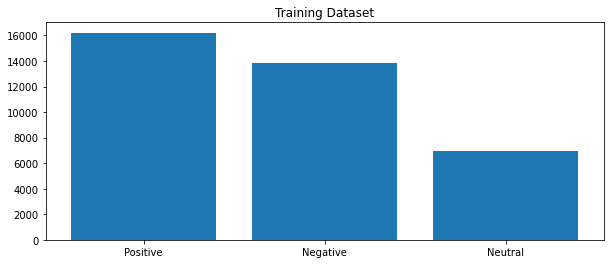

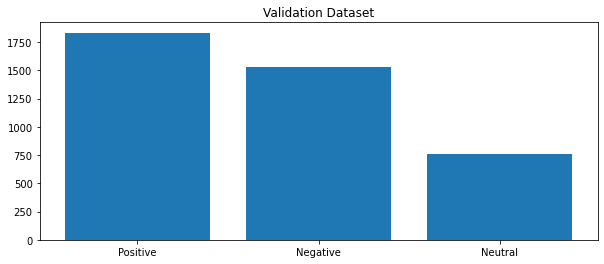

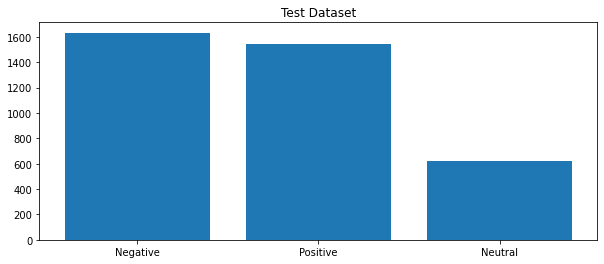

In [ ]:
%matplotlib inline
plot_distribution(df_train,'target','Training Dataset')
plot_distribution(df_val,'target','Validation Dataset')
plot_distribution(df_test,'target','Test Dataset')

In [ ]:
np_labels = np.array(df_train.target.tolist())
classes = np.unique(np_labels)
classes

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [ ]:
df_train= df_train.dropna(subset=['target'])
df_test= df_test.dropna(subset=['target'])
df_val= df_val.dropna(subset=['target'])

# Data preparation

###TweetTokenizer for BERT like model

In [ ]:
tokenizer = TweetTokenizer()
""" Bert proposed method to cleanup dataset"""

""" Added characters “”–-‘’ """
def normalizeToken(token):
    lowercased_token = token.lower()

    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "‘" or token=='’':
            return "'"
        elif token == "…":
            return "..."
        elif token == "“" or token=="”":
            return "\""
        elif token == "–-":
            return "--"
        else:
            return token

""" Added control_char_regex | html.unscape | unicode.decode """
def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])
    control_char_regex = re.compile(r'[\r\n\t]+')
    normTweet = re.sub(control_char_regex, ' ', normTweet)
    normTweet = html.unescape(normTweet)
    normTweet = unidecode.unidecode(normTweet)

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())


In [ ]:
print(
  normalizeTweet(
      "SC has first two presumptive cases of coronavirus #COVIDIsEverywhere, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
  )
)

SC has first two presumptive cases of coronavirus #COVIDIsEverywhere , DHEC confirms HTTPURL ... via @USER


In [ ]:
df_train['final'] = df_train['OriginalTweet'].apply(lambda x: normalizeTweet(x))
df_test['final'] = df_test['OriginalTweet'].apply(lambda x: normalizeTweet(x))
df_val['final'] = df_val['OriginalTweet'].apply(lambda x: normalizeTweet(x))

In [ ]:
df_val[:1][['OriginalTweet','final']]

,OriginalTweet,final
39626,COVID-19 Lockdown: Ilorin residents flood mark...,COVID - 19 Lockdown : Ilorin residents flood m...


In [ ]:
df_test= df_test.dropna(subset=['final'])
df_train= df_train.dropna(subset=['final'])
df_val= df_val.dropna(subset=['final'])

In [ ]:
print(len(df_test),len(df_train), len(df_val))

3798 37041 4116


###BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [ ]:
config.PRE_TRAINED_MODEL

'digitalepidemiologylab/covid-twitter-bert-v2'

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL,normalization=True, use_fast=False)

In [ ]:
def tokenize_function(text):
  """Perform required preprocessing steps for pretrained BERT.
  @param    text (string): pre-processed-text to be processed.
  @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
  @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                tokens should be attended to by the model.
  """
  tok = bert_tokenizer(text  #Normalized text
                       ,add_special_tokens=True, # Add `[CLS]` and `[SEP]`
                       padding="max_length",  # Pad sentence to max length
                       max_length = config.MAX_LEN,  # Max length to truncate/pad
                       truncation=True,   
                       return_tensors="pt"  # Return PyTorch tensor
                       )
  return tok['input_ids'], tok['attention_mask']

In [ ]:
df_train['input_ids'], df_train['attention_mask'] = zip(*df_train['final'].map(tokenize_function))

In [ ]:
df_test['input_ids'], df_test['attention_mask'] = zip(*df_test['final'].map(tokenize_function))

In [ ]:
df_val['input_ids'], df_val['attention_mask'] = zip(*df_val['final'].map(tokenize_function))

In [ ]:
df_test.sample(1)

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,target,final,input_ids,attention_mask
826,826,827,45779,Laval,12-03-2020,Me coming back from the grocery store!! ???\r\...,Neutral,Neutral,Me coming back from the grocery store ! ! ? ? ...,"[[tensor(101), tensor(2033), tensor(2746), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


### Download BERT pre-trained model

In [ ]:
bertweet = AutoModel.from_pretrained(config.PRE_TRAINED_MODEL)

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Create Dataset

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train.target.to_list())
y_test = encoder.transform(df_test.target.to_list())
y_val = encoder.transform(df_val.target.to_list())
print(y_train[1], y_test[1])

2 2


In [ ]:
class TweetDataset(torch.utils.data.Dataset):
  def __init__(self, df, encoded_y):
      self.df = df
      self.y = encoded_y

  def __len__(self):
      return len(self.df)

  def __getitem__(self, idx):
      item = self.df.iloc[idx]
      text = item['final']
      label = self.y[idx]
      return {
          'text': text,
          'input_ids' : torch.tensor(item['input_ids']).to(device),
          'attention_mask' : torch.tensor(item['attention_mask']).to(device),
          'labels' : torch.tensor(label).to(device)
      }

In [ ]:
len(df_test)

3798

In [ ]:
test_set = TweetDataset(df_test,y_test)
train_set = TweetDataset(df_train, y_train)
val_set = TweetDataset(df_val, y_val)

In [ ]:
print(len(test_set))
print(test_set[0])

3798
{'text': 'TRENDING : New Yorkers encounter empty supermarket shelves ( pictured , Wegmans in Brooklyn ) , sold-out online grocers ( FoodKick , MaxDelivery ) as #coronavirus-fearing shoppers stock up HTTPURL HTTPURL', 'input_ids': tensor([[  101,  9874,  2075,  1024,  2047, 19095,  2015,  8087,  4064, 17006,
         15475,  1006, 15885,  1010,  2057, 25494,  2015,  1999,  6613,  1007,
          1010,  2853,  1011,  2041,  3784, 24665, 10085,  2545,  1006,  2833,
         29493,  2243,  1010,  4098,  9247, 16402,  2100,  1007,  2004,  1001,
         21887, 23350,  1011, 14892,  4497,  7347,  4518,  2039,  8299,  3126,
          2140,  8299,  3126,  2140,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


### Create Dataloader

In [ ]:
config.BATCH_SIZE

32

In [ ]:
len(test_set)

3798

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=config.BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.BATCH_SIZE)

In [ ]:
data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].shape)
print(data['labels'].shape)
print(data['attention_mask'].shape)

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
torch.Size([32, 1, 128])
torch.Size([32])
torch.Size([32, 1, 128])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


# Model

### Bert Classifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

Sursa: https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/ 

In [ ]:
# Link: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/ 

%%time

class TweetClassifier(nn.Module):
    """Bert Model for Classification Tasks."""

    def __init__(self, bertModel, out_feat, freeze_bert=False):
        """
        @param    bertModel: a BertModel object
        @param    out_feat: number of classes
        """
        super().__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = bertModel.config.hidden_size, 50, out_feat

        # Instantiate BERT model
        self.bert = bertModel

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in,H),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(H, D_out),
            nn.Softmax(dim=1)
        )

        # Freeze the pre-trained layers of BERT model
        if freeze_bert:
          for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask )

        # Extract the last hidden state of the token `[CLS]` for classification task ---- https://www.tensorflow.org/text/tutorials/classify_text_with_bert
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 41.2 µs


In [ ]:
model = TweetClassifier(bertweet, len(classes)).to(device) 

In [ ]:
model

TweetClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementw

### Class Weights

In [ ]:
def get_weights():
  weights=class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train), y = y_train)
  weights=torch.tensor(weights,dtype=torch.float)

  print('Class Weights for train dataset: ', weights)
  return weights

###  Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

* Batch size: 16 or 32
* Learning rate (Adam): 5e-5, 3e-5 or 2e-5
* Number of epochs: 2, 3, 4

Huggingface provided the run_glue.py script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.

Sursa: https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

In [ ]:
def initialize_model(freeze_bert=False):
  model = TweetClassifier(bertweet, len(classes), freeze_bert=freeze_bert).to(device) 
  optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, eps=config.EPS, correct_bias=False, no_deprecation_warning=True)
  total_steps = len(train_dataloader) * config.EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
  return model, optimizer, scheduler

In [ ]:
def initialize_loss(weights=None):
  if weights==None:
    loss_fn = nn.CrossEntropyLoss().to(device)
  else:
    loss_fn = nn.CrossEntropyLoss(
        weight=weights,       # weight should be a 1D Tensor assigning weight to each of the classes.
        reduction='mean'      # the loss will be normalized by the sum of the corresponding. It is the default.
        ).to(device)
  
  return loss_fn

Usually, you increase the weight for minority classes, so that their loss also 
increases and forces the model to learn these samples.

In [ ]:
model, optimizer, scheduler = initialize_model()
weights = get_weights()
loss_fn = initialize_loss(weights)

Class Weights for train dataset:  tensor([0.7836, 2.0455, 0.8098])


### Training Loop

We will train our Bert Classifier for 20 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

In [ ]:
def evaluate(model, val_dataloader):
  """After the completion of each training epoch, measure the model's performance
  on our validation set.
  """
  # Put the model into the evaluation mode. The dropout layers are disabled during
  # the test time.
  model.eval()

  # Tracking variables
  val_accuracy = []
  val_loss = []

  for batch in val_dataloader:
    # Load batch to GPU
    mask = batch['attention_mask'].to(device)
    input_id = batch['input_ids'].squeeze(1).to(device)
    targets = batch["labels"].to(device)

    # Compute logits
    with torch.no_grad():
        logits = model(input_id, mask)

    # Compute loss
    loss = loss_fn(logits, targets)
    val_loss.append(loss.item())

    # Get the predictions
    preds = torch.argmax(logits, dim=1).flatten()

    # Calculate the accuracy rate
    batch_acc = (preds == targets).cpu().numpy().mean() 
    val_accuracy.append(batch_acc)

  # Compute the average accuracy and loss over the validation set.
  val_loss = np.mean(val_loss)
  val_accuracy = np.mean(val_accuracy)

  return val_loss, val_accuracy



def train(model, train_dataloader, val_dataloader, model_path, fold, optimizer, scheduler,loss_fn, epochs=config.EPOCHS):
  print(f"Start training fold {fold}...\n")

  # train_accuracy = Accuracy().to(device)
  # valid_accuracy = Accuracy().to(device)

  min_epoch_loss = np.Inf
  log_info = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
  trigger_times = 0
  patience = 6
  best_model = model

  for epoch in range(epochs):
    # =======================================
    #               Training
    # =======================================
    # Print the header of the result table
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12}| {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Tracking variables
    batch_loss, batch_counts = 0, 0  # updated from 20 to 20 batches
    epoch_loss = []
    epoch_accuracy = []

    # Put the model into the training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
      batch_counts +=1

      # Zero out any previously calculated gradients
      model.zero_grad() 
      
      # Load batch to GPU
      mask = batch['attention_mask'].to(device)
      input_id = batch['input_ids'].squeeze(1).to(device)
      targets = batch["labels"].to(device)

      # Perform a forward pass. This will return logits.
      logits =  model(input_id, mask)
      
      #Compute Loss and accumulate the loss values
      loss = loss_fn(logits, targets)
      batch_loss += loss.item()
      epoch_loss.append(loss.item())

      #Get the predictions
      preds = torch.argmax(logits,dim=1).flatten()

      # Calculate the accuracy rate
      batch_acc = (preds==targets).cpu().numpy().mean()
      epoch_accuracy.append(batch_acc)

      # Perform a backward pass to calculate gradients
      loss.backward()

      # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and the learning rate
      optimizer.step()  # updates the parameters, called once the gradients are computed (eg. backward())
      scheduler.step()
      
      # Print the loss values and time elapsed for every 20 batches
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
          # Calculate time elapsed for 20 batches
          time_elapsed = time.time() - t0_batch

          # Print training results
          print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_acc:^12.6f} |{'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
          
          # Reset batch tracking variables
          batch_loss, batch_counts = 0, 0
          t0_batch = time.time()

    # Calculate the average loss and accuracy over the entire training data
    epoch_loss = np.mean(epoch_loss)
    epoch_accuracy = np.mean(epoch_accuracy)

    # After the completion of each training epoch, measure the model's performance
    # on our validation set.
    val_loss, val_accuracy = evaluate(model, val_dataloader)
    # Print performance over the entire training data
    time_elapsed = time.time() - t0_epoch

    print("-"*70)
    print(f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f} |{epoch_accuracy:^12.6f}| {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
    log_info['train_loss'].append((epoch, epoch_loss))
    log_info['train_acc'].append((epoch, epoch_accuracy))
    log_info['val_loss'].append((epoch, val_loss))
    log_info['val_acc'].append((epoch, val_accuracy))
    print("-"*70)
    
    if val_loss < min_epoch_loss:
      min_epoch_loss = val_loss
      trigger_times = 0 
      print('Trigger times: 0')
      print(f"Saving model with val loss: {val_loss} and validation accuracy: {val_accuracy}")
      torch.save(model, model_path)
      best_model = model
    else:
      trigger_times += 1
      print('Trigger Times:', trigger_times)
    if trigger_times > patience:
        print('Early stopping!\nStart to test process.')
        return best_model, log_info

  print(f"Training Complete for fold {fold}!")
  return best_model, log_info

In [ ]:
print(config.MODEL_PATH)
print(config.BATCH_SIZE)

/content/drive/MyDrive/models/bertweet_3_cls_corona_3_iunie_v2.pt
32


In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train), y = y_train)
weights = torch.tensor(weights,dtype=torch.float)

In [ ]:
train_set = TweetDataset(df_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.BATCH_SIZE)

val_set = TweetDataset(df_val,y_val)
val_dataloader= torch.utils.data.DataLoader(val_set, batch_size=config.BATCH_SIZE)

### Start training

In [ ]:
weights = get_weights()

Class Weights for train dataset:  tensor([0.7836, 2.0455, 0.8098])


In [ ]:
config.MODEL_PATH

'/content/drive/MyDrive/models/bertweet_3_cls_corona_3_iunie_v2.pt'

In [ ]:
set_seed(42)    
model, optimizer, scheduler = initialize_model()
loss_fn = initialize_loss(weights)

best_model, log_info = train(model, train_dataloader, val_dataloader, config.MODEL_PATH, 0, optimizer, scheduler, loss_fn, epochs=config.EPOCHS)

In [ ]:
config.MODEL_PATH

'/content/drive/MyDrive/models/ctbert_3_cls_corona_4_iunie_v1.pt'

#Model performance

### Plot history

In [ ]:
log_info

{'train_acc': [(0, 0.7402959935321595),
  (1, 0.8435366510959396),
  (2, 0.8819237333812433),
  (3, 0.9001549586776859),
  (4, 0.9095176068990298),
  (5, 0.9141124685591089),
  (6, 0.9140361121092346),
  (7, 0.9199155587495508),
  (8, 0.923895077254761),
  (9, 0.9271537010420409),
  (10, 0.9298733381243263),
  (11, 0.9309108875314409),
  (12, 0.9318226733740568),
  (13, 0.9350094322673373),
  (14, 0.9369610132950054),
  (15, 0.938887890765361),
  (16, 0.9411606180380884),
  (17, 0.9417040962989579),
  (18, 0.9425934243621991),
  (19, 0.9432604204096299)],
 'train_loss': [(0, 0.8134766483024175),
  (1, 0.7115757927121852),
  (2, 0.6759327952569653),
  (3, 0.6590083092568891),
  (4, 0.6506815222883413),
  (5, 0.6479336757904928),
  (6, 0.6463351669990027),
  (7, 0.6427619193853596),
  (8, 0.6373959963500735),
  (9, 0.6336093857825509),
  (10, 0.6321684699755884),
  (11, 0.6331523368952302),
  (12, 0.6310602727614844),
  (13, 0.6270711331499423),
  (14, 0.62563079977224),
  (15, 0.6242482

In [ ]:
def Convert(tup, di):
  di={"epoch":[],"val":[]}
  for a, b in tup:
    di['epoch'].append(a)
    di['val'].append(b)
  return di

def plot_performance(log_info):
  dict_train={}
  dict_val={}

  dict_train = Convert(log_info['train_acc'], dict_train)
  dict_val = Convert(log_info['val_acc'], dict_val)

  dict_train_loss={}
  dict_val_loss={}

  dict_train_loss = Convert(log_info['train_loss'], dict_train_loss)
  dict_val_loss = Convert(log_info['val_loss'], dict_val_loss)

  fig = plt.figure()
  plt.plot(dict_train['epoch'], dict_train['val'] , 'bo', label = 'Training Accuracy')
  plt.plot(dict_val['epoch'], dict_val['val'], 'b', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()


  fig = plt.figure()
  plt.plot(dict_train_loss['epoch'], dict_train_loss['val'] , 'bo', label = 'Training Loss')
  plt.plot(dict_val_loss['epoch'], dict_val_loss['val'], 'b', label = 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

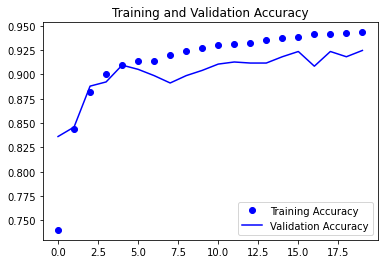

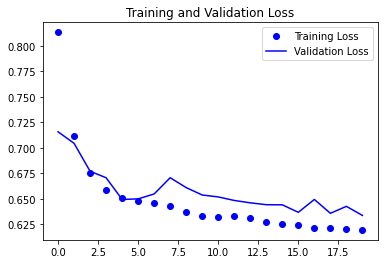

In [ ]:
plot_performance(log_info)

###Evaluate on test data

In [ ]:
config.MODEL_PATH

'/content/drive/MyDrive/models/ctbert_3_cls_corona_4_iunie_v1.pt.pt'

In [ ]:
loaded_model = torch.load(config.MODEL_PATH)

In [ ]:
%%time
test_loss, test_accuracy = evaluate(loaded_model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


CPU times: user 1min 13s, sys: 60.7 ms, total: 1min 14s
Wall time: 1min 13s


In [ ]:
test_accuracy

0.9367360580595875

In [ ]:
# torch.save(model, config.MODEL_PATH+".pt")

In [ ]:
# config.MODEL_PATH=config.MODEL_PATH+".pt"

In [ ]:
print("Model ",config.MODEL_PATH,":\nLOSS =",test_loss,"\nACCURACY =",test_accuracy)

Model  /content/drive/MyDrive/models/ctbert_3_cls_corona_4_iunie_v1.pt.pt :
LOSS = 0.6309489131975574 
ACCURACY = 0.9367360580595875


### Prediction

In [ ]:
def get_targets_and_predictios_as_tensors(dataloader,model):
  predictions = []
  targets = []
  for batch in dataloader:
    input_ids = batch['input_ids']
    masks = batch['attention_mask']
    batch_targets = batch['labels']

    with torch.no_grad():
      batch_predictions = model(input_ids.squeeze(1),masks)
      batch_predictions = torch.argmax(batch_predictions, dim=1).flatten()
      predictions.append(batch_predictions.cpu())
      targets.append(batch_targets.cpu())


  final_predictions = np.concatenate(predictions)
  final_targets = np.concatenate(targets)

  return final_targets, final_predictions

In [ ]:
%%time
final_targets, final_predictions = get_targets_and_predictios_as_tensors(test_dataloader, loaded_model)

correct_classifications = sum(final_targets==final_predictions)
misclassified = len(final_predictions) - correct_classifications

print("TEST DATASET:  number of samples misclassified: ", str(misclassified),"/",str(len(final_predictions)))
print("TEST DATASET:  number of samples correct classified: ", correct_classifications,"/",str(len(final_predictions)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


TEST DATASET:  number of samples misclassified:  240 / 3798
TEST DATASET:  number of samples correct classified:  3558 / 3798
CPU times: user 1min 13s, sys: 48.6 ms, total: 1min 13s
Wall time: 1min 13s


###Confusion Metrics and Report Classification

In [ ]:
classes

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [ ]:
y_test

array([0, 2, 2, ..., 1, 0, 2])

In [ ]:
df_test.head(3) # 2-pozitiv, 1-neutru, 0-negativ

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,target,final,input_ids,attention_mask
0,0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,Negative,TRENDING : New Yorkers encounter empty superma...,"[[tensor(0), tensor(51862), tensor(22), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Positive,When I could n't find hand sanitizer at Fred M...,"[[tensor(0), tensor(205), tensor(8), tensor(15...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Positive,Find out how you can protect yourself and love...,"[[tensor(0), tensor(1856), tensor(50), tensor(...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
def decode_sentiment(score):    
  if score==0:
    return 'Negative'
  elif score==1:
    return 'Neutral'
  else:
    return 'Positive'


*Classification Report for Test Data:
               precision    recall  f1-score   support

    Negative       0.95      0.96      0.95      1633
     Neutral       0.86      0.85      0.86       619
    Positive       0.95      0.95      0.95      1546

    accuracy                           0.94      3798
   macro avg       0.92      0.92      0.92      3798
weighted avg       0.94      0.94      0.94      3798



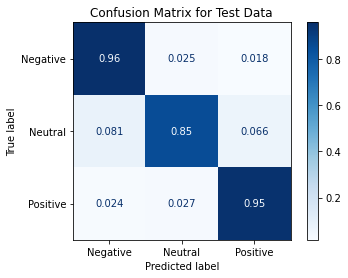

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


print ('\n*Classification Report for Test Data:\n', classification_report(final_targets, final_predictions, target_names=classes))

cm = confusion_matrix(final_targets, final_predictions, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Neutral','Positive'])


disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()

###Error Analysis

In [ ]:
config.MODEL_PATH

'/content/drive/MyDrive/models/ctbert_3_cls_corona_4_iunie_v1.pt.pt'

In [ ]:
cnt= 0
nb = 0
# f = open("/content/drive/MyDrive/models/confusion_CTbert_4_iunie_NEG_POS.txt", "a")

for i,j in zip(final_targets, final_predictions):
  if i==1 and j==0:
    print(str(cnt),'\tLABEL TRUE: ',decode_sentiment(i),'\tLABEL PREDICTED: ',decode_sentiment(j),'\tTEXT: ',df_test['OriginalTweet'].iloc[cnt])
    # f.write(str(cnt)+'\tTRUE: '+decode_sentiment(i)+'\tPREDICTED: '+decode_sentiment(j)+'\tTEXT: '+ df_test['OriginalTweet'].iloc[cnt]+"\n")

    nb += 1
  cnt += 1

# f.close()

34 	LABEL TRUE:  Neutral 	LABEL PREDICTED:  Negative 	TEXT:  So not due to #Brexit at all then &gt;&gt; Supermarkets begin #foodrationing after wave of #coronavirus-fuelled panic buying https://t.co/AKgkHxO0tW
122 	LABEL TRUE:  Neutral 	LABEL PREDICTED:  Negative 	TEXT:  With all of the public school, college and university closures due to #coronavirus, a lot of food insecure students will go hungry. As you stock your pantry, consider donating to your local food pantry to help feed a kid. #CoronaVirusUpdate
143 	LABEL TRUE:  Neutral 	LABEL PREDICTED:  Negative 	TEXT:  When the #CPTSD therapist recommends that you go out among people to isolate yourself less and the government then advises you to stay at home, recommend self-isolation, and you then consider to not even go out shopping anymore and instead do that online too ???? #Coronavirus

https://t.co/r8erNbiv3P
167 	LABEL TRUE:  Neutral 	LABEL PREDICTED:  Negative 	TEXT:  LOOK: Panic buying at a supermarket in Makati, Manila as the 

In [ ]:
nb

70

# Bibliografie


* https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/

* https://github.com/Nitesh0406/-Fine-Tuning-BERT-base-for-Sentiment-Analysis./blob/main/BERT_Sentiment.ipynb  -- nu l am urmat dar pare a fi bun